In [40]:
import json
import pickle
import logging
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

### Model building baseline with mlflow tracking 

In [41]:
def read_csv(file_name: str, path="data/data_processed") -> pd.DataFrame:
    """
    Read csv file
    :param file_name: file name
    :param path: path to the file
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [42]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")

In [43]:
df_tickets.shape

(18961, 4)

In [44]:
df_tickets.sample(5)

,complaint_what_happened,ticket_classification,processed_text,relevant_topics
4131,There are unknown hard inquiries on my credit ...,"Credit reporting, credit repair services, or o...",inquiri credit report request verif inquiri me...,Credit Report or Prepaid Card
17492,"I paid my loan in full on XXXX XXXX, 2015 and ...",Consumer Loan + Vehicle loan,paid loan letter state york motor informationt...,Mortgage/Loan
10086,several years ago I opened a checking account ...,Bank account or service + Checking account,sever year check account bank part product lin...,Bank Account Services
14905,Dear Sir or Madam:I recently obtained a copy o...,"Credit reporting, credit repair services, or o...",sir madam credit report credit bureaus item er...,Credit Report or Prepaid Card
17617,I have asked for chase bank to please modify m...,Mortgage + Conventional adjustable mortgage (ARM),bank loan adjust rate pay month month loan pa...,Mortgage/Loan


In [45]:
df_tickets.relevant_topics.value_counts() #positivo para desbalance but, la vida es así y hay que seguir adelante

relevant_topics
Bank Account Services            7069
Credit Report or Prepaid Card    6295
Mortgage/Loan                    5597
Name: count, dtype: int64

In [46]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")


def data_transform(df: pd.DataFrame):
    """This function transform the data into X and y
    Args:
      df (pd.DataFrame): dataframe with the data
    Returns:
      X (pd.Series): series with the text
      y (pd.Series): series with the labels"""
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y


def read_idx2label(json_path: str) -> pd.Series:
    """This function read the json file and return a dictionary
    Args:
      json_path (str): path to the json file
     Returns:
      idx2label (dict): dictionary with the mapping"""
    with open(json_path) as f:
        idx2label = json.load(f)
    return idx2label


def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    """This function decode the labels into idx
    Args:
      labels (pd.Series): series with the labels
      idx2label (dict): dictionary with the mapping
     Returns:
      labels (pd.Series): series with the labels decoded
    """
    return labels.map(idx2label)


def fit_transform(X: pd.Series) -> np.ndarray:
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    #save count vectorizer for data preprocessing in the main app (deploy)
    joblib.dump(count_vectorizer, 'data/data_processed/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    return X_vectorized


def transform_tfidf(X_vectorized: object) -> np.ndarray:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, 'data/data_processed/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    return X_tfidf

def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    filepath = os.path.join("data", "data_processed", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    This function splits the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
    Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train, y_test

def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
        model (object): model
        name_model (str): name of the model
        developer (str): developer name
        X_train (np.array): array with the vectorized data for train
        X_test (np.array): array with the vectorized data for test
        y_train (pd.Series): series with the labels for train
        y_test (pd.Series): series with the labels for test
    Returns:
        metric (list): list with the metrics"""
    
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info("ROC AUC Score Train: %s", roc_auc_score_train)
        logger.info("ROC AUC Score Test: %s", roc_auc_score_test)

        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the confusion matrix with labels decoded
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models_{name_model}")

        return metric


def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search


def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

2025/10/26 18:08:35 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/26 18:08:35 INFO mlflow.store.db.utils: Updating database tables
2025-10-26 18:08:35 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-10-26 18:08:35 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-10-26 18:08:35 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-10-26 18:08:35 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [47]:


idx2label = read_idx2label(json_path="data/data_processed/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes</h2>


2025/10/19 21:41:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:41:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.88
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86      5689
weighted avg       0.86      0.86      0.86      5689



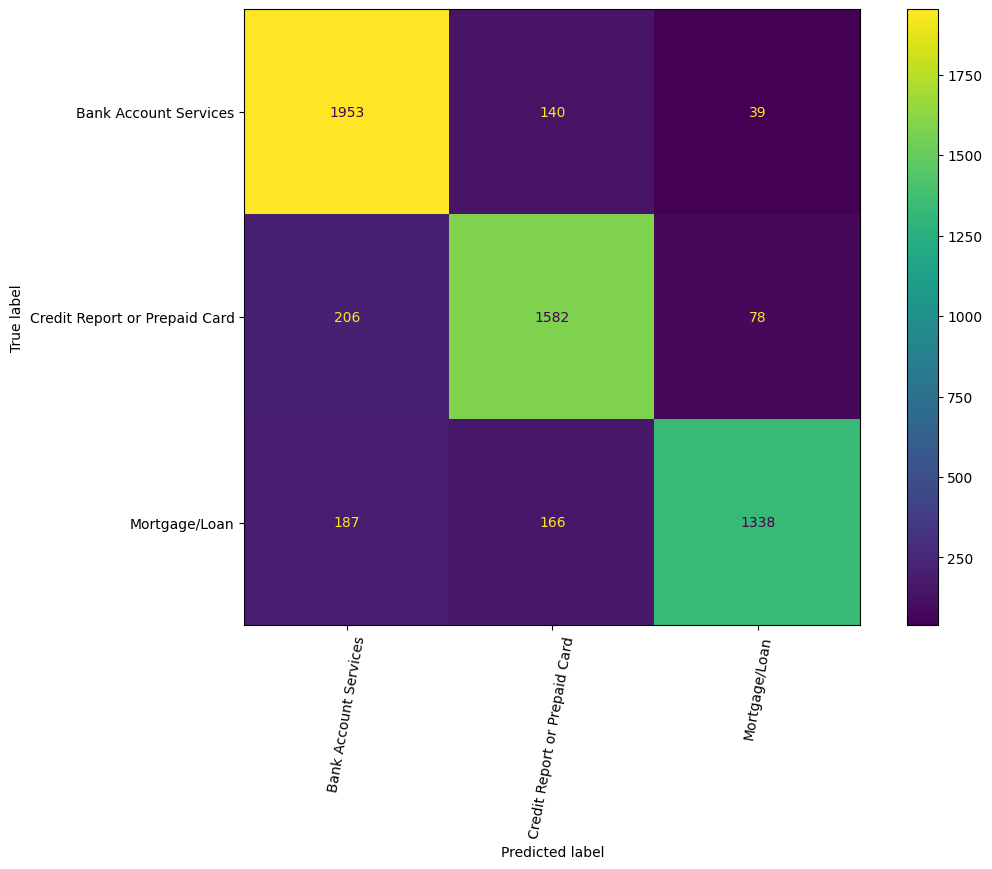

2025/10/19 21:41:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:41:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]

In [12]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes con GreadSearch</h2>

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.8473478684769604
Best Hyperparameters:  {'alpha': 1}


2025/10/19 21:41:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:41:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.88
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86      5689
weighted avg       0.86      0.86      0.86      5689



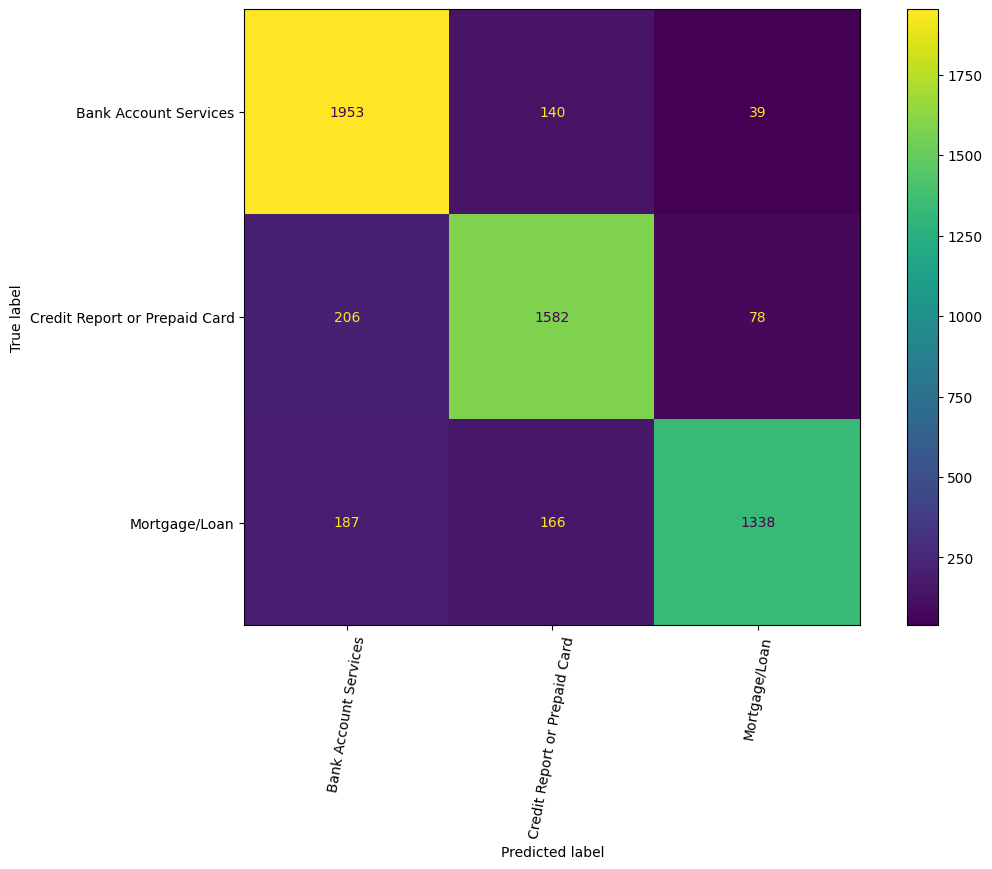

2025/10/19 21:41:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:41:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]

In [13]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring="f1_micro")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

<h2 style="color: pink;">Logistic Regression</h2>

2025/10/19 21:41:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.99
Test Accuracy:  0.97
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4937
           1       0.98      1.00      0.99      4429
           2       1.00      0.98      0.99      3906

    accuracy                           0.99     13272
   macro avg       0.99      0.99      0.99     13272
weighted avg       0.99      0.99      0.99     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2132
           1       0.96      0.98      0.97      1866
           2       0.98      0.96      0.97      1691

    accuracy                           0.97      5689
   macro avg       0.97      0.97      0.97      5689
weighted avg       0.97      0.97      0.97      5689



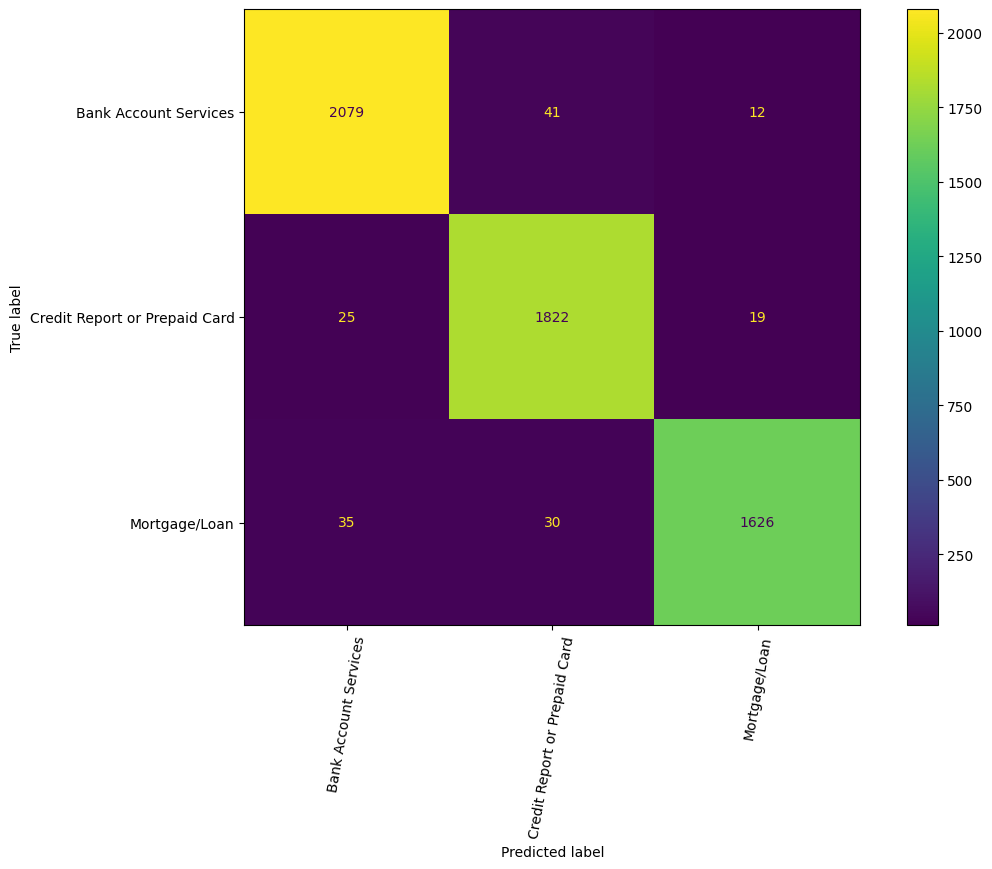

2025/10/19 21:41:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:41:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[1.0, 1.0, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97]

In [14]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

<h2 style="color: pink;">Logistic Regression with GreadSearch</h2>

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9839310533263845
Best Hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


2025/10/19 21:42:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:42:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  1.0
Test Accuracy:  0.98
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4937
           2       1.00      1.00      1.00      4937

    accuracy                           1.00     14811
   macro avg       1.00      1.00      1.00     14811
weighted avg       1.00      1.00      1.00     14811

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2132
           1       0.98      0.98      0.98      1866
           2       0.98      0.99      0.98      1691

    accuracy                           0.98      5689
   macro avg       0.98      0.98      0.98      5689
weighted avg       0.98      0.98      0.98      5689



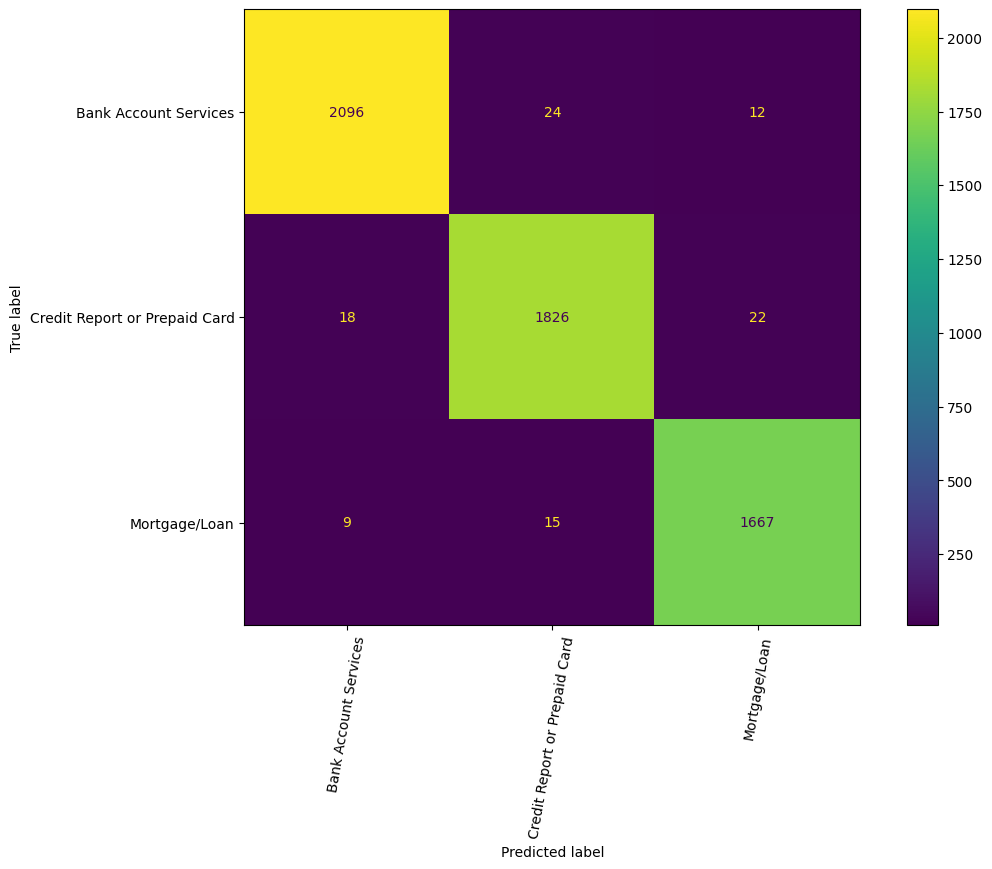

2025/10/19 21:42:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:42:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[1.0, 1.0, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98]

In [15]:
# rebalance of the data
smote = SMOTE()
# transform the dataset with the SMOTE algorithm
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# define the model with the balanced class_weight
log_reg = LogisticRegression(class_weight='balanced')

log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

grid_search_log = grid_search(log_reg, folds, log_params, scoring="f1_micro")
grid_search_log.fit(X_train_res, y_train_res)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Maria", 
                              X_train=X_train_res,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train_res,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

<h2 style="color: pink;">Decision Tree Classifier</h2>

2025/10/19 21:42:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:42:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  1.0
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4429
           2       1.00      1.00      1.00      3906

    accuracy                           1.00     13272
   macro avg       1.00      1.00      1.00     13272
weighted avg       1.00      1.00      1.00     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2132
           1       0.86      0.86      0.86      1866
           2       0.85      0.85      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.86      0.86      5689
weighted avg       0.86      0.86      0.86      5689



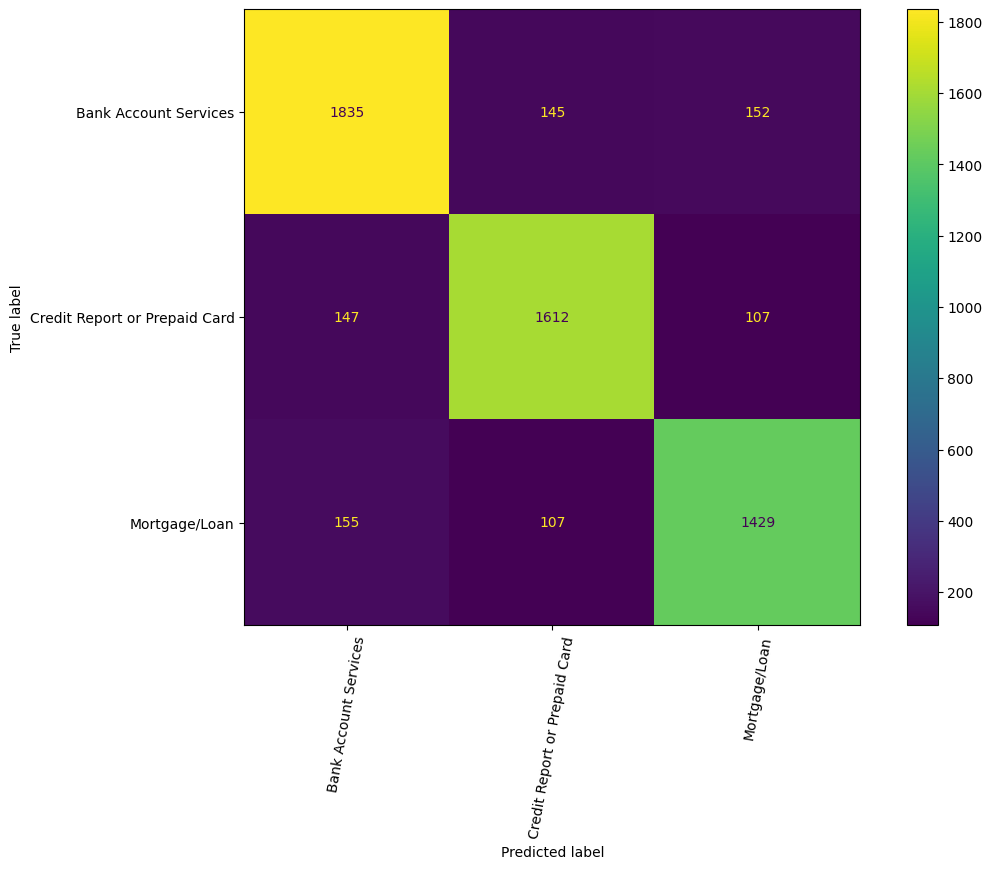

2025/10/19 21:42:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:42:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[1.0, 0.89, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86]

In [16]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Maria",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

<h2 style="color: pink;">Decision Tree Classifier with Gread Search</h2>

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best Score:  0.870619206133405
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'splitter': 'best'}


2025/10/19 21:43:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:44:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.94
Test Accuracy:  0.87
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4937
           1       0.94      0.96      0.95      4429
           2       0.95      0.93      0.94      3906

    accuracy                           0.94     13272
   macro avg       0.94      0.94      0.94     13272
weighted avg       0.94      0.94      0.94     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2132
           1       0.86      0.89      0.88      1866
           2       0.88      0.85      0.86      1691

    accuracy                           0.87      5689
   macro avg       0.87      0.87      0.87      5689
weighted avg       0.87      0.87      0.87      5689



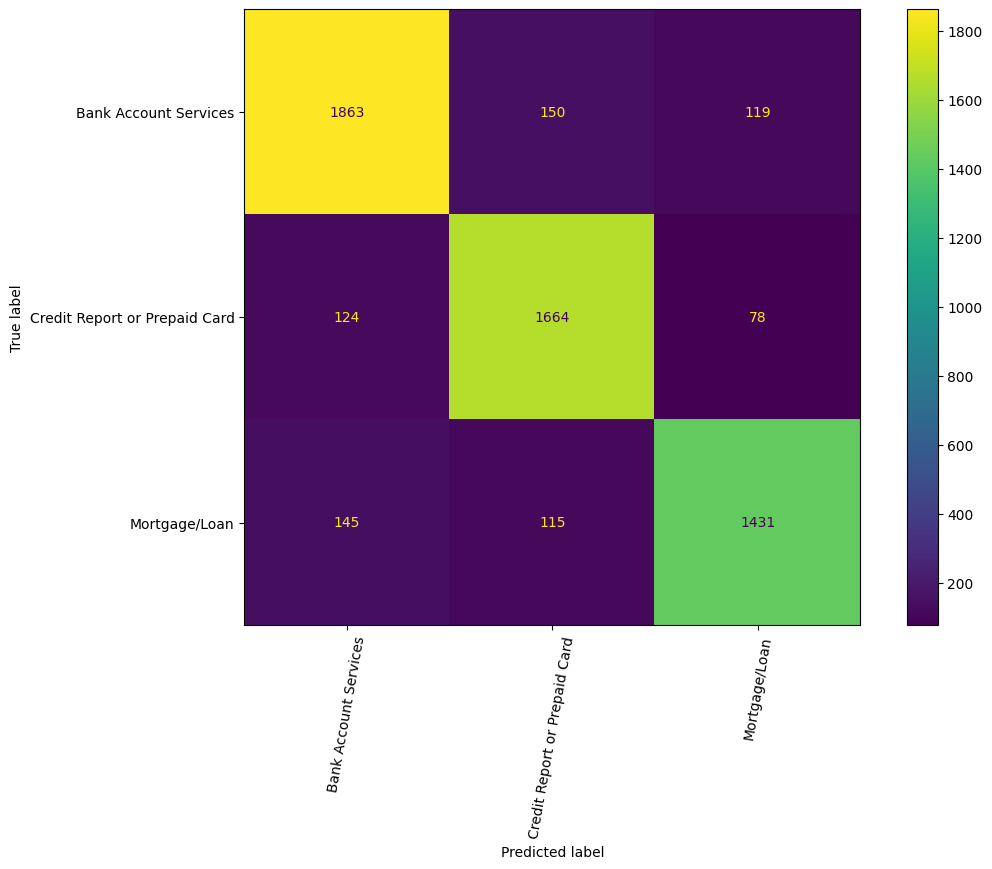

2025/10/19 21:44:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 21:44:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[1.0, 0.94, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87]

In [17]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,6,7,8,None],
    'min_samples_leaf': [2,3,4,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='f1_macro')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

* No olvides ejecutar: mlflow ui --backend-store-uri sqlite:///mlflow.db para visualizar los resultados

<h2 style="color: pink;">Hacer inferencias con el modelo</h2>

In [48]:
import mlflow
          
# loaded_model = mlflow.set_active_model(model_id="m-1e70ef500d674925801583c34869644d")

In [49]:
logged_model = "file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/models/m-1e70ef500d674925801583c34869644d/artifacts"

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [50]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/models/m-1e70ef500d674925801583c34869644d/artifacts
  flavor: mlflow.sklearn
  run_id: 71364a23ea7640c88defb53a0356cf42

In [51]:
assert X_train.toarray().shape[0] == y_train.shape[0]

In [52]:
lr_model = mlflow.sklearn.load_model(logged_model)

In [53]:
lr_model.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'deprecated',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(class_weight='balanced'),
 'n_jobs': -1,
 'param_grid': {'C': [0.01, 1, 10],
  'penalty': ['l1', 'l2'],
  'solver': ['liblinear', 'newton-cg', 'saga']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'f1_micro',
 'verbose': 1}

In [54]:
lr_model.predict(X_test)

array(['2', '0', '2', ..., '1', '0', '0'], shape=(5689,), dtype=object)

In [55]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [59]:
runs = mlflow.search_runs()
# Extrae los IDs únicos de los experimentos
experiment_ids = runs['experiment_id'].unique()

In [60]:
experiment_ids

array(['1'], dtype=object)

In [58]:
client.create_experiment("regression_models")

'2'

In [61]:
runs = client.search_runs(experiment_ids=["1"])
for run in runs:
    print(run.info)

<RunInfo: artifact_uri='file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/1e7c8846effd404f9ffd4787c6d5426f/artifacts', end_time=1760931854184, experiment_id='1', lifecycle_stage='active', run_id='1e7c8846effd404f9ffd4787c6d5426f', run_name='DecisionTreeClassifierCV', start_time=1760931838529, status='FINISHED', user_id='Cesar'>
<RunInfo: artifact_uri='file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/0ffe1f471e9e4107a0720d06ea6fb957/artifacts', end_time=1760931748185, experiment_id='1', lifecycle_stage='active', run_id='0ffe1f471e9e4107a0720d06ea6fb957', run_name='DecisionTreeClassifier', start_time=1760931740369, status='FINISHED', user_id='Cesar'>
<RunInfo: artifact_uri='file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/71364a23ea7640c88defb53a0356cf42/artifacts', end_time=1760931737543, experiment_id='1', lifecycle_stage='active', run_id='71364a23ea7640c88defb53a03

💚 Ahora vayamos a la UI y miremos los resultados de los modelos y hagamos un registro de un par de modelos con mejor performancce. 

<p align="center">
  <img src="https://pbs.twimg.com/media/EoOBoWyWEAAA8In.jpg" width="400" style="display: block; margin: auto;">
</p>

### Promote a model

In [62]:
runs= client.search_runs(
    experiment_ids='1',
    filter_string="", #se puede usar un tag en especial o algún parámetro de interés ej: 'tags.model = valor que usaste
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.precision_test DESC"]

)

In [63]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse_valid: {run.data.metrics['precision_test']}")

run id: 71364a23ea7640c88defb53a0356cf42, rmse_valid: 0.9824335577825786
run id: 15c0babd9a6d40fcb4fe4bc6ecac4b23, rmse_valid: 0.9716247042374007
run id: 1e7c8846effd404f9ffd4787c6d5426f, rmse_valid: 0.8716876918644566
run id: c10e2a4f4916440aa8e88585886a6a70, rmse_valid: 0.8601577541286356
run id: 8261289d62f2457d97451d4760570c0e, rmse_valid: 0.8601577541286356


In [ ]:
run_id = "71364a23ea7640c88defb53a0356cf42"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "tickets_classifiers")

In [80]:
run_id = "71364a23ea7640c88defb53a0356cf42"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "tickets_classifiers")

Registered model 'tickets_classifiers' already exists. Creating a new version of this model...


MlflowException: Unable to find a logged_model with artifact_path model under run 71364a23ea7640c88defb53a0356cf42

In [67]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
run = client.get_run(run_id)
print(run.info)
print(run.data)

<RunInfo: artifact_uri='file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/71364a23ea7640c88defb53a0356cf42/artifacts', end_time=1760931737543, experiment_id='1', lifecycle_stage='active', run_id='71364a23ea7640c88defb53a0356cf42', run_name='LogisticRegressionCVSmote', start_time=1760931729724, status='FINISHED', user_id='Cesar'>
<RunData: metrics={'precision_test': 0.9824335577825786,
 'precision_train': 1.0,
 'recall_test': 0.9824222183160485,
 'recall_train': 1.0,
 'roc_auc_test': 1.0,
 'roc_auc_train': 1.0}, params={'C': '10',
 'developer': 'Maria',
 'model': 'LogisticRegressionCVSmote',
 'penalty': 'l1',
 'solver': 'saga'}, tags={'mlflow.runName': 'LogisticRegressionCVSmote',
 'mlflow.source.name': 'c:\\Users\\Cesar\\Documents\\repositories\\cursos\\platzi\\curso_mlops\\.mlops\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'Cesar'}>


In [68]:
artifacts = client.list_artifacts(run_id)
for artifact in artifacts:
    print(artifact.path)


In [69]:
model_name = "tickets_classifiers"
latest_versions = client.get_latest_versions(name=model_name)
for version in latest_versions:
    print(f" version: {version.version} , actual stage: {version._current_stage}")

 version: 2 , actual stage: Staging


In [70]:
client.transition_model_version_stage(
    name=model_name,
    version=3,
    stage="Staging"
)

MlflowException: Model Version (name=tickets_classifiers, version=3) not found

In [74]:
client.transition_model_version_stage(
    name=model_name,
    version=2,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1761524645464, current_stage='Production', deployment_job_state=None, description='The model version 2 was transitioned to Production on 2025-10-26', last_updated_timestamp=1761526030161, metrics=None, model_id=None, name='tickets_classifiers', params=None, run_id='1e7c8846effd404f9ffd4787c6d5426f', run_link='', source='file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/models/m-3b97d55ad1004bb9b47a0b8bd42cfcd6/artifacts', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [75]:
client.update_model_version(
    name=model_name, 
    version=2,
    description=f"The model version {2} was transitioned to Production on {datetime.today().date()}"
)

<ModelVersion: aliases=[], creation_timestamp=1761524645464, current_stage='Production', deployment_job_state=None, description='The model version 2 was transitioned to Production on 2025-10-26', last_updated_timestamp=1761526031227, metrics=None, model_id=None, name='tickets_classifiers', params=None, run_id='1e7c8846effd404f9ffd4787c6d5426f', run_link='', source='file:///c:/Users/Cesar/Documents/repositories/cursos/platzi/curso_mlops/tracking/mlruns/1/models/m-3b97d55ad1004bb9b47a0b8bd42cfcd6/artifacts', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [76]:
type(y_test)

pandas.core.series.Series

## Sometamos a prueba el modelo que hemos registrado para producción

In [77]:
import scipy

In [78]:
def testint_model_from_mlflow(model_name: str, stage:str, X_test: scipy.sparse._csr.csr_matrix, Y_test: pd.Series):
    """this function tests a model from mlflow
    Args:
        model_name (str): name of the model
        stage (str): stage of the model
        X_test (scipy.sparse._csr.csr_matrix): test data
        Y_test (scipy.sparse._csr.csr_matrix): test target
    Returns:
        float: rmse of the model
    
    """
    model_uri = f"models:/{model_name}/{stage}"
    model = mlflow.pyfunc.load_model(model_uri)
    y_pred = model.predict(X_test)
    acc_score = round(accuracy_score(Y_test, y_pred), 2)
    return {"rmse": acc_score}

In [79]:
%time
testint_model_from_mlflow(model_name= "tickets_classifiers", stage="Production", X_test=X_test, Y_test=y_test)

CPU times: total: 0 ns
Wall time: 0 ns


{'rmse': 0.87}

## Ventajas de MLflow:

* Gestión de Ciclo de Vida: Facilita el seguimiento de experimentos, versionado de modelos y reproducción de resultados.
* Interoperabilidad: Es compatible con múltiples frameworks de aprendizaje automático y se integra fácilmente en flujos de trabajo existentes.
* Abierto y Modular: Ofrece una arquitectura modular que permite la flexibilidad y personalización.
* Trazabilidad y Reproducibilidad: Registra métricas, parámetros y artefactos para reproducir modelos y resultados.
* Comunidad Activa: Amplia comunidad de usuarios y contribuciones continuas.

## Desventajas de MLflow:
* Complejidad para Grandes Volúmenes de Datos: Puede enfrentar dificultades al manejar grandes volúmenes de datos o flujos de trabajo muy complejos.
* Curva de Aprendizaje: Requiere tiempo para familiarizarse con todas sus funcionalidades y componentes.
* Limitaciones en Algunas Funcionalidades: Algunas funcionalidades pueden no ser tan avanzadas o flexibles como en otras herramientas especializadas.

## Alternativas a MLflow:
* TensorBoard: Enfoque específico para TensorFlow, útil para visualizar gráficamente métricas, grafos de modelos y más.
* DVC (Data Version Control): Se enfoca en versionado de datos y modelos, y gestión de experimentos.
* Comet.ml: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.
* Weights & Biases: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.


## 💚 Conclusiones
* Podemos trackear metadata

* Registrar modelos

* Obtener los requirimientos del ambiente de desarrollo donde fue entrenado los modelos

* Podemos hacer un seguimiento de los modelos y compararlos de forma fácil y amigable con la interfaz de MLflow y en código

